# Population Estimates: Design the panel-view input for CF

In [1]:
from glob import glob
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
SJ_RES_PARCELS_FP = os.path.join(PERMIT_INPUT_FP, 'san_jose_parcels_res.geojson')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * Permits
sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])

100%|██████████| 3324/3324 [00:00<00:00, 15781.13it/s]


In [4]:
model_params = {'area_threshold_main': 30, 'area_threshold_small': 20,
                  'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                  'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0}

In [5]:
def generate_CF_input(parcel_apn, model_params, sat_imagery, title=True):
    # Collect parcel data
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # Prepare data
    inferred_buildings_parcel = {'2016': inferred_buildings_2016_parcel,
                                 '2020': inferred_buildings_2020_parcel}
    
    osm_buildings_parcel = {'2016': osm_buildings_parcel,
                            '2020': osm_buildings_parcel}
    print('[INFO] OSM HISTORIC DATA NOT YET INCORPORATED')
    
    # Incorporate OSM data
    parcel_buildings, _ = process_parcel_buildings(
        inferred_buildings_parcel, osm_buildings_parcel, parcel_bounds, model_params)
    
    # Define axis 
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))

    # Get individual axis
    ax1, ax2 = axs

    for ax in axs:
        ax.axis('off')

    # Add titles
    if title:
        ax1.set_title('2020')
        ax2.set_title('2016')


    for year, ax in zip(['2020', '2016'], (ax1, ax2)):
        # * NAIP
        # Add buffer to parcel_bounds to get neighborhood/street context
        parcel_bounds_buffered = parcel_bounds.copy()
        parcel_bounds_buffered['geometry'] = parcel_bounds.to_crs('EPSG:26910').buffer(10)

        # Get imagery
        file_name = get_file_name_from_parcel(
            parcel_apn, sat_imagery['sj_parcels_res'], sat_imagery['tiles_gdf'][year])
        img_file, superres_file = find_image_file_and_superrestile(
            sat_imagery['img_fp'][year], sat_imagery['tif_fp'][year], file_name)

        with rasterio.open(superres_file) as src:
            out_image, out_transform = rasterio.mask.mask(
                src, parcel_bounds_buffered.to_crs('EPSG:26910')['geometry'], crop=True, nodata=255)

        # Plot
        rasterio.plot.show(out_image, transform=out_transform, ax=ax, alpha=1)

        ax.axis('off')
        # * Output
        output_year = parcel_buildings[year].copy()
        if output_year is not None:
            output_year = output_year.loc[output_year['main_building_flag'] == False]
            output_year.geometry = output_year.geometry.exterior
            output_year.to_crs('EPSG:26910').plot(ax=ax, color='red')

        # * Parcel outline
        parcel_bounds.to_crs('EPSG:26910').plot(
            ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)

    plt.show()
    
    return parcel_buildings

[INFO] OSM HISTORIC DATA NOT YET INCORPORATED


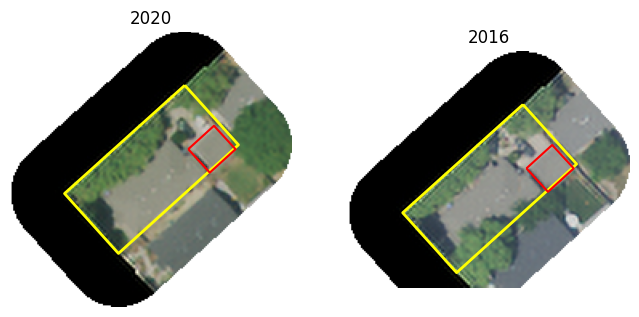

{'2016':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.671434   
 1               False      True          0.902141   
 
                                             geometry        area  
 0  POLYGON ((-121.92103 37.34371, -121.92103 37.3...  145.360342  
 1  POLYGON ((-121.92084 37.34380, -121.92079 37.3...   38.872002  ,
 '2020':    main_building_flag  OSM_flag  build_confidence  \
 0                True     False          0.805904   
 1               False      True          0.953307   
 
                                             geometry        area  
 0  POLYGON ((-121.92102 37.34372, -121.92102 37.3...  172.592401  
 1  POLYGON ((-121.92084 37.34380, -121.92079 37.3...   38.872002  }

In [6]:
generate_CF_input(parcel_apn='23041017', 
                  model_params=model_params, 
                  sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res,
                 'tiles_gdf': tiles_gdf})